In [1]:
import pandas as pd
!pip install detoxify
from detoxify import Detoxify
import spacy
from spacy import displacy
from semeval2021 import f1
from semeval2021 import evaluate

     |████████████████████████████████| 1.2 MB 5.3 MB/s 
     |████████████████████████████████| 3.5 MB 38.5 MB/s 
     |████████████████████████████████| 67 kB 5.3 MB/s 
     |████████████████████████████████| 895 kB 43.3 MB/s 
     |████████████████████████████████| 596 kB 44.7 MB/s 
     |████████████████████████████████| 6.8 MB 26.8 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [3]:
comments = pd.read_csv('tsd_trial.csv')
comments.head(10)

,spans,text
0,"[15, 16, 17, 18, 19, 27, 28, 29, 30, 31]",Because he's a moron and a bigot. It's not any...
1,"[29, 30, 31, 32, 33, 34]",How about we stop protecting idiots and let na...
2,"[166, 167, 168, 169, 170, 171]","If people were smart, they would Boycott th..."
3,"[87, 88, 89, 90, 91, 92]",Trump Claimed that Russia will never invade th...
4,[],As long as your willing to pay a lot more for ...
5,"[8, 9, 10, 11, 12]",Only an idiot would use and believe anything t...
6,"[265, 266, 267, 268, 269, 270, 271, 272, 273, ...",Thanks a lot douchebag. You're the reason the ...
7,[],kick all the non human criminal illegals out o...
8,"[38, 39, 40, 41, 42, 43]",Because driving under Ontario laws is stupid e...
9,"[277, 278, 279, 280, 281, 282, 283, 284, 285, ...",You're wrong. The delay between retirement an...


In [4]:
# Lower case all the words
comments['cleaned_text'] = comments['text'].apply(lambda x: x.lower())
comments.head(10)

,spans,text,cleaned_text
0,"[15, 16, 17, 18, 19, 27, 28, 29, 30, 31]",Because he's a moron and a bigot. It's not any...,because he's a moron and a bigot. it's not any...
1,"[29, 30, 31, 32, 33, 34]",How about we stop protecting idiots and let na...,how about we stop protecting idiots and let na...
2,"[166, 167, 168, 169, 170, 171]","If people were smart, they would Boycott th...","if people were smart, they would boycott th..."
3,"[87, 88, 89, 90, 91, 92]",Trump Claimed that Russia will never invade th...,trump claimed that russia will never invade th...
4,[],As long as your willing to pay a lot more for ...,as long as your willing to pay a lot more for ...
5,"[8, 9, 10, 11, 12]",Only an idiot would use and believe anything t...,only an idiot would use and believe anything t...
6,"[265, 266, 267, 268, 269, 270, 271, 272, 273, ...",Thanks a lot douchebag. You're the reason the ...,thanks a lot douchebag. you're the reason the ...
7,[],kick all the non human criminal illegals out o...,kick all the non human criminal illegals out o...
8,"[38, 39, 40, 41, 42, 43]",Because driving under Ontario laws is stupid e...,because driving under ontario laws is stupid e...
9,"[277, 278, 279, 280, 281, 282, 283, 284, 285, ...",You're wrong. The delay between retirement an...,you're wrong. the delay between retirement an...


### Using spacy to tokenize the words

In [6]:
!spacy download en_core_web_sm
sp = spacy.load('en_core_web_sm')

# Import pre-trained toxicBERT model from Huggingface
unbiased_model = Detoxify('unbiased', device='cuda')

     |████████████████████████████████| 12.0 MB 5.1 MB/s 
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')


Downloading:   0%|          | 0.00/481 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/878k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.29M [00:00<?, ?B/s]

## Using toxicBERT to predict whether a word is toxic or not

In [7]:
def get_span_predicated(index, text):
    sentence_content = sp(text)
    text_words = []
    for token in sentence_content:
        if token.pos_ != 'PUNCT':
            text_words.append(str(token.text))

    toxic_prediction = unbiased_model.predict(text_words)

    span_predicted = '['
    span = []
    for i in range(0, len(toxic_prediction['toxicity'])):
        if toxic_prediction['toxicity'][i] > 0.8:
            cur = text.find(text_words[i])
            for j in range(0, len(text_words[i])):
                span.append(str(cur))
                cur += 1
    span_predicted += ', '.join(span)
    span_predicted += ']'

    return span_predicted

spans_predicted = []
for index, row in comments.iterrows():
    spans_predicted.append(get_span_predicated(int(index), row['cleaned_text']))

comments['spans_predicted'] = spans_predicted
comments.head(10)

,spans,text,cleaned_text,spans_predicted
0,"[15, 16, 17, 18, 19, 27, 28, 29, 30, 31]",Because he's a moron and a bigot. It's not any...,because he's a moron and a bigot. it's not any...,"[15, 16, 17, 18, 19]"
1,"[29, 30, 31, 32, 33, 34]",How about we stop protecting idiots and let na...,how about we stop protecting idiots and let na...,"[29, 30, 31, 32, 33, 34]"
2,"[166, 167, 168, 169, 170, 171]","If people were smart, they would Boycott th...","if people were smart, they would boycott th...","[166, 167, 168, 169, 170, 171]"
3,"[87, 88, 89, 90, 91, 92]",Trump Claimed that Russia will never invade th...,trump claimed that russia will never invade th...,"[87, 88, 89, 90, 91, 92]"
4,[],As long as your willing to pay a lot more for ...,as long as your willing to pay a lot more for ...,"[188, 189, 190, 191, 192, 193, 194, 195, 196, ..."
5,"[8, 9, 10, 11, 12]",Only an idiot would use and believe anything t...,only an idiot would use and believe anything t...,"[8, 9, 10, 11, 12]"
6,"[265, 266, 267, 268, 269, 270, 271, 272, 273, ...",Thanks a lot douchebag. You're the reason the ...,thanks a lot douchebag. you're the reason the ...,"[171, 172, 173, 174, 175, 176, 178, 179, 180, ..."
7,[],kick all the non human criminal illegals out o...,kick all the non human criminal illegals out o...,"[73, 74, 75, 76, 77]"
8,"[38, 39, 40, 41, 42, 43]",Because driving under Ontario laws is stupid e...,because driving under ontario laws is stupid e...,"[38, 39, 40, 41, 42, 43]"
9,"[277, 278, 279, 280, 281, 282, 283, 284, 285, ...",You're wrong. The delay between retirement an...,you're wrong. the delay between retirement an...,"[288, 289, 290, 291, 292, 293, 294, 295]"


# Evaluation

In [8]:
comments["f1_scores"] = comments.apply(lambda row: f1(row.spans_predicted, row.spans), axis=1)
comments.head(10)

,spans,text,cleaned_text,spans_predicted,f1_scores
0,"[15, 16, 17, 18, 19, 27, 28, 29, 30, 31]",Because he's a moron and a bigot. It's not any...,because he's a moron and a bigot. it's not any...,"[15, 16, 17, 18, 19]",0.869565
1,"[29, 30, 31, 32, 33, 34]",How about we stop protecting idiots and let na...,how about we stop protecting idiots and let na...,"[29, 30, 31, 32, 33, 34]",1.000000
2,"[166, 167, 168, 169, 170, 171]","If people were smart, they would Boycott th...","if people were smart, they would boycott th...","[166, 167, 168, 169, 170, 171]",1.000000
3,"[87, 88, 89, 90, 91, 92]",Trump Claimed that Russia will never invade th...,trump claimed that russia will never invade th...,"[87, 88, 89, 90, 91, 92]",1.000000
4,[],As long as your willing to pay a lot more for ...,as long as your willing to pay a lot more for ...,"[188, 189, 190, 191, 192, 193, 194, 195, 196, ...",0.250000
5,"[8, 9, 10, 11, 12]",Only an idiot would use and believe anything t...,only an idiot would use and believe anything t...,"[8, 9, 10, 11, 12]",1.000000
6,"[265, 266, 267, 268, 269, 270, 271, 272, 273, ...",Thanks a lot douchebag. You're the reason the ...,thanks a lot douchebag. you're the reason the ...,"[171, 172, 173, 174, 175, 176, 178, 179, 180, ...",1.000000
7,[],kick all the non human criminal illegals out o...,kick all the non human criminal illegals out o...,"[73, 74, 75, 76, 77]",0.363636
8,"[38, 39, 40, 41, 42, 43]",Because driving under Ontario laws is stupid e...,because driving under ontario laws is stupid e...,"[38, 39, 40, 41, 42, 43]",1.000000
9,"[277, 278, 279, 280, 281, 282, 283, 284, 285, ...",You're wrong. The delay between retirement an...,you're wrong. the delay between retirement an...,"[288, 289, 290, 291, 292, 293, 294, 295]",0.923077


F1 = 0.81 ± 0.01


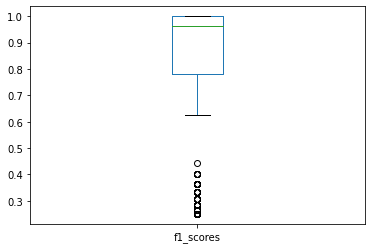

In [9]:
from scipy.stats import sem
_ = comments.f1_scores.plot(kind="box")
print (f"F1 = {comments.f1_scores.mean():.2f} ± {sem(comments.f1_scores):.2f}")

In [10]:
# make sure that the ids match the ones of the scores
predictions = comments.spans_predicted.to_list()
ids = comments.index.to_list()

# write in a prediction file named "spans-pred.txt"
with open("spans-pred.txt", "w") as out:
  for uid, text_scores in zip(ids, predictions):
    out.write(f"{str(uid)}\t{str(text_scores)}\n")

! head spans-pred.txt

0	[15, 16, 17, 18, 19]
1	[29, 30, 31, 32, 33, 34]
2	[166, 167, 168, 169, 170, 171]
3	[87, 88, 89, 90, 91, 92]
4	[188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 201, 202, 203, 204, 205, 206]
5	[8, 9, 10, 11, 12]
6	[171, 172, 173, 174, 175, 176, 178, 179, 180, 181, 182, 183, 184, 186, 187, 188, 189, 190, 191, 192, 193, 171, 172, 173, 174, 175, 176, 178, 179, 180, 181, 182, 183, 184, 186, 187, 188, 189, 190, 191, 192, 193, 171, 172, 173, 174, 175, 176, 178, 179, 180, 181, 182, 183, 184, 186, 187, 188, 189, 190, 191, 192, 471, 472, 473, 474, 479, 480, 481, 482, 511, 512, 513, 514, 515, 479, 480, 481, 482]
7	[73, 74, 75, 76, 77]
8	[38, 39, 40, 41, 42, 43]
9	[288, 289, 290, 291, 292, 293, 294, 295]


In [11]:
gold = comments.spans.to_list()
ids = comments.index.to_list()

# write in a prediction file named "spans-pred.txt"
with open("spans-gold.txt", "w") as out:
  for uid, text_scores in zip(ids, gold):
    out.write(f"{str(uid)}\t{str(text_scores)}\n")

! head spans-gold.txt


0	[15, 16, 17, 18, 19, 27, 28, 29, 30, 31]
1	[29, 30, 31, 32, 33, 34]
2	[166, 167, 168, 169, 170, 171]
3	[87, 88, 89, 90, 91, 92]
4	[]
5	[8, 9, 10, 11, 12]
6	[265, 266, 267, 268, 269, 270, 271, 272, 273, 274, 275, 276, 277, 278, 279, 280, 281, 282, 283, 284, 285, 286, 287, 288, 289, 290, 291, 292, 293, 294, 295, 296, 297, 298, 299, 300, 301, 302, 303, 304, 305, 306, 307, 308, 309, 310, 311, 312, 313, 314, 315, 316, 317, 318, 319, 320, 321, 322, 323, 324, 325, 326, 327, 328, 329, 330, 331, 332, 333, 334, 335, 336, 337, 338, 339, 340, 341, 342, 343, 344, 345, 346, 347, 348, 349, 350, 351, 352, 353, 354, 355, 356, 357, 358, 359, 360, 361, 362, 363, 364, 365, 366, 367, 368, 369, 370, 371, 372, 373, 374, 375, 376, 377, 378, 379, 380, 381, 382, 383, 384, 385, 386, 387, 388, 389, 390, 391, 392, 393, 394, 395, 396, 397, 398, 399, 400, 401, 402, 403, 404, 405, 406, 407, 408, 409, 410, 411, 412, 413, 414, 415, 416, 417, 418, 419, 420, 421, 422, 423, 424, 425, 426, 427, 428, 429, 430, 431, 432, 4

In [12]:
predictions = open("spans-pred.txt", "r")
gold = open("spans-gold.txt", "r")

score = evaluate(predictions, gold)
print(score)

(0.5892532526600114, 0.015664592479534913)
